In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import os
import scipy

GIMME_DIR = "/home/isaac/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "simout/")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess
from scipy.stats import expon

## Define the function to draw the plots

In [2]:
def plot_per_lambda(lambda_dists):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
    axarr = [a for b in axarr for a in b]


    for k, ax in zip(sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k))
        coltimes = lambda_dists[k]
        ax.hist(coltimes)
        ax.set_ylabel('N Species', color='b')
        ax.set_xlabel('Colonization Time', color='b')
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ## Super annoying
        #ax.get_xaxis().set_ticks(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5)))
        #ax.set_xticklabels(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/6)))#, fontsize=7)
        data = sorted(coltimes)
        loc, sc = expon.fit(data, floc=0)
        print("{} {}".format(k, sc))
        rv = expon(scale=sc)
        x = np.linspace(0, max(data), 100)

        ax1 = ax.twinx()
        ax1.plot(x, rv.pdf(x), color='black')
        ax1.get_yaxis().set_ticks([])
    plt.tight_layout()

In [60]:
zoom_x = 5
def plot_pidxy_per_lambda(lambda_dists, xaxis_label, nbins=10):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True, sharey=True)
    axarr = [a for b in axarr for a in b]


    for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k))
        coltimes = lambda_dists[k]
        ax.hist(coltimes, color="red", bins=nbins, normed=True)
        if i in [0, 3]:
            ax.set_ylabel('N Species')
            #ax.get_yaxis().set_ticks([])
        if i in [3, 4, 5]:
            ax.set_xlabel(xaxis_label)
            #ax.get_xaxis().set_ticks([])

        x0, x1 = ax.get_xlim()
        ax.set_xlim(0, x1/zoom_x)
        ## Super annoying
        #ax.get_xaxis().set_ticks(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5)))
        #ax.set_xticklabels(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/6)))#, fontsize=7)
        data = sorted(coltimes)
        loc, sc = expon.fit(data, floc=0)
        ## Don't print the scaling factor
        #print("{} {}".format(k, sc))
        rv = expon(scale=sc)
        x = np.linspace(0, max(data), 100)

        ax1 = ax.twinx()
        ax1.plot(x, rv.pdf(x), color='black')
        ax1.get_yaxis().set_ticks([])
        ax1.set_xlim(xmin=0)
        ax1.set_ylim(ymin=0)
        x0, x1 = ax.get_xlim()
        ax.set_xlim(0, x1/zoom_x)

        
    plt.tight_layout()

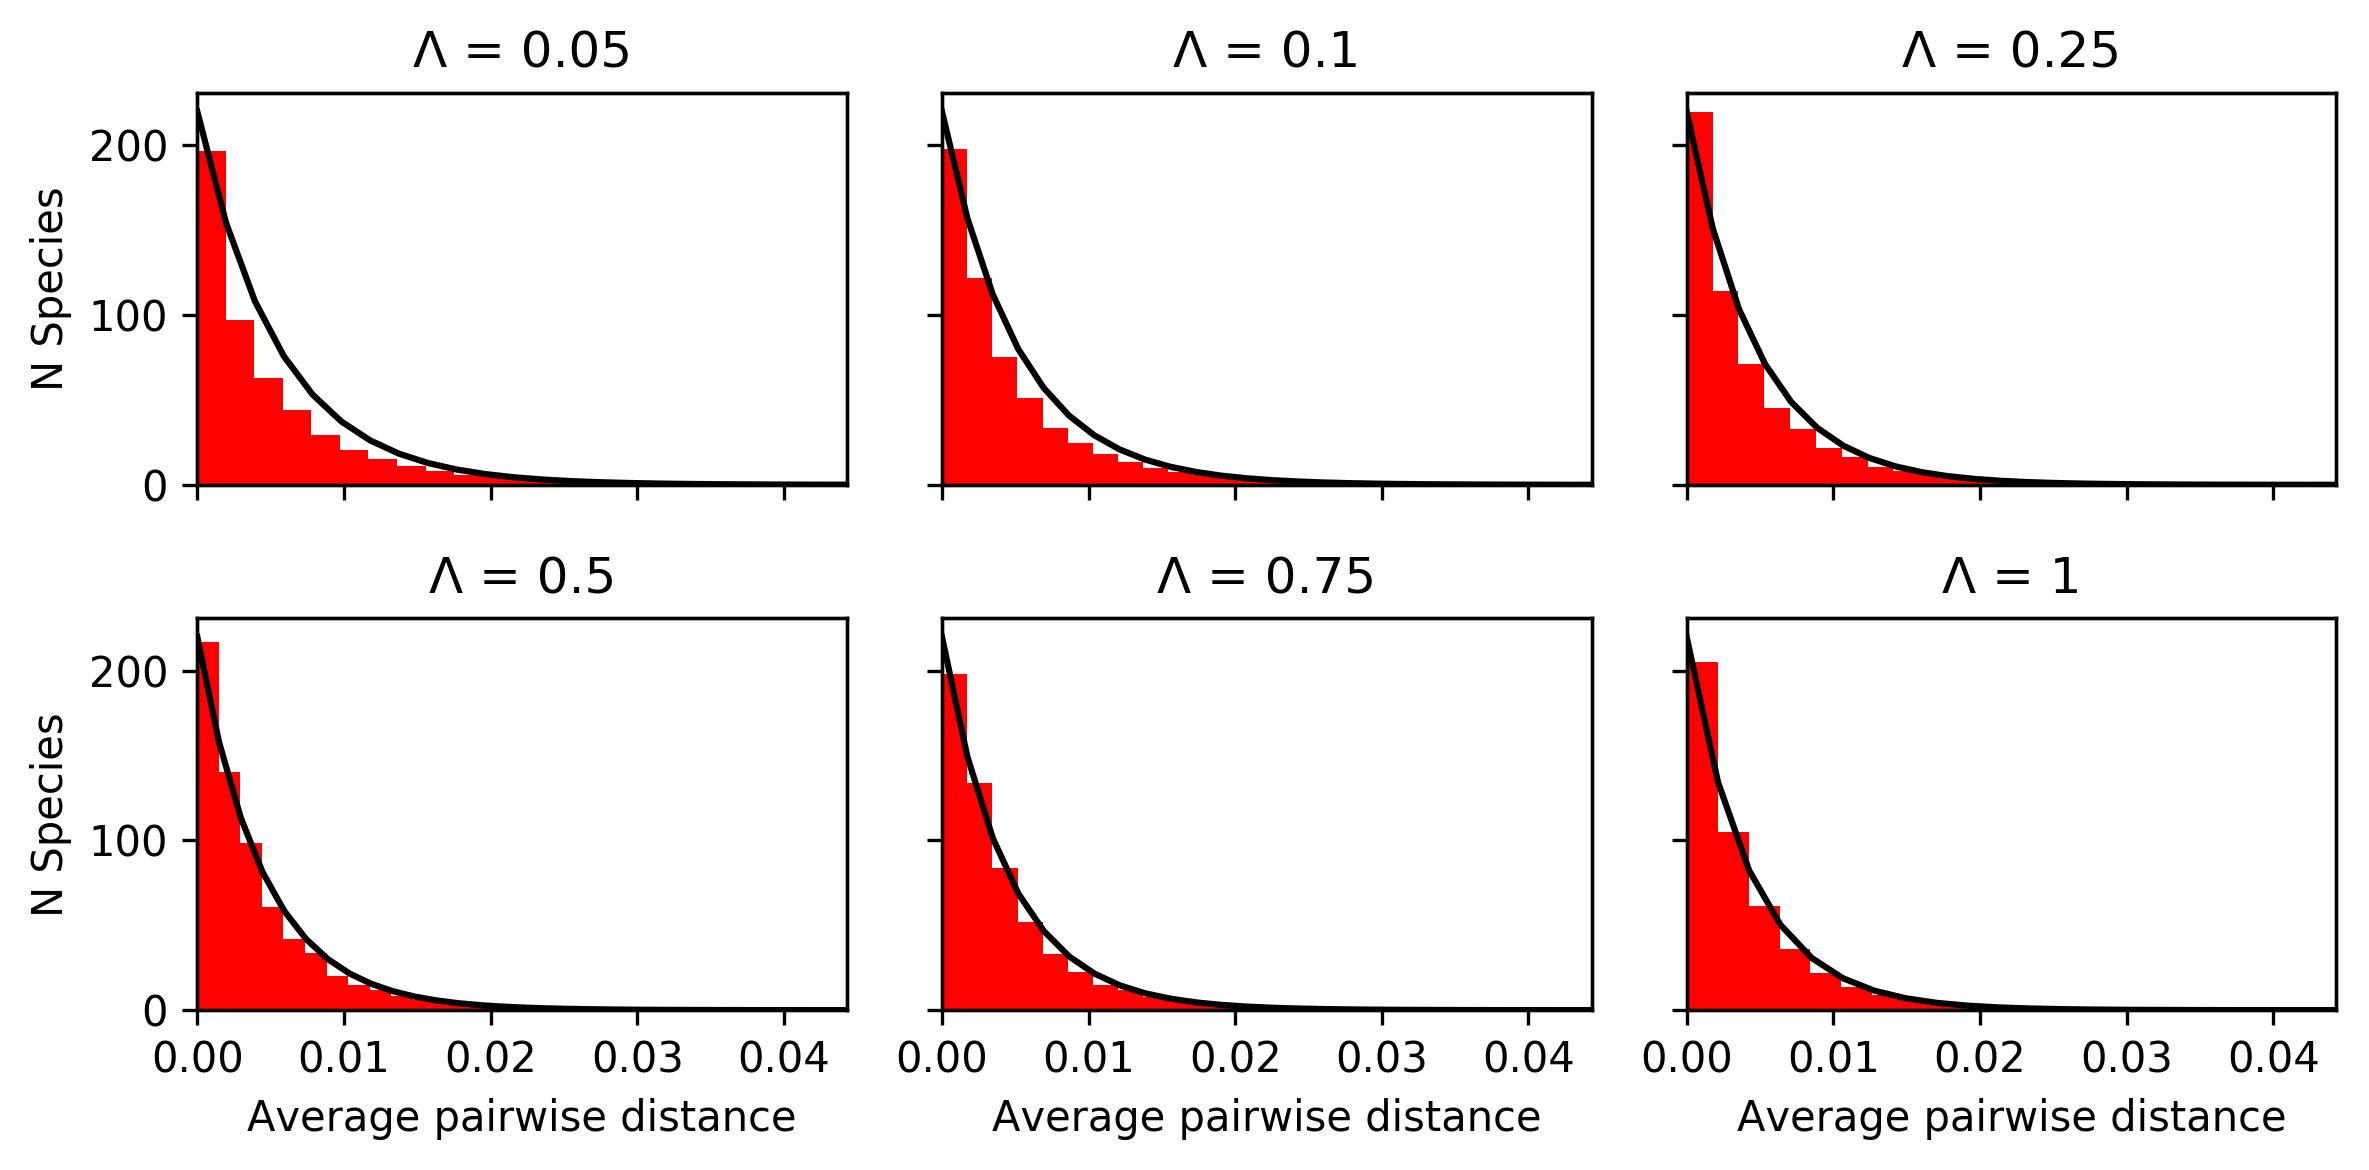

In [61]:
plot_pidxy_per_lambda(lambda_dists, "Average pairwise distance", nbins=100)

# **Colonization times**
## Gather all the colonization time vectors for all the simulations

In [5]:
files = glob.glob(SIMOUT_DIR + "*5000*/coltimes.txt")
dat = []
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = [float(x.translate(None, "[],")) for x in line.strip().split()]
            ## Convert colonization time, which is recorded as the timestep of 
            ## colonization, to absolute time, basically subtract each coltime
            ## per species from the "current" time
            l = [l[0]] + [l[1] - x for x in l[2:]]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 11526


## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

Got n coltimes per lambda:
0.25 - 29035	0.5 - 12084	0.05 - 56926	0.1 - 41095	1 - 312329	0.75 - 17486	

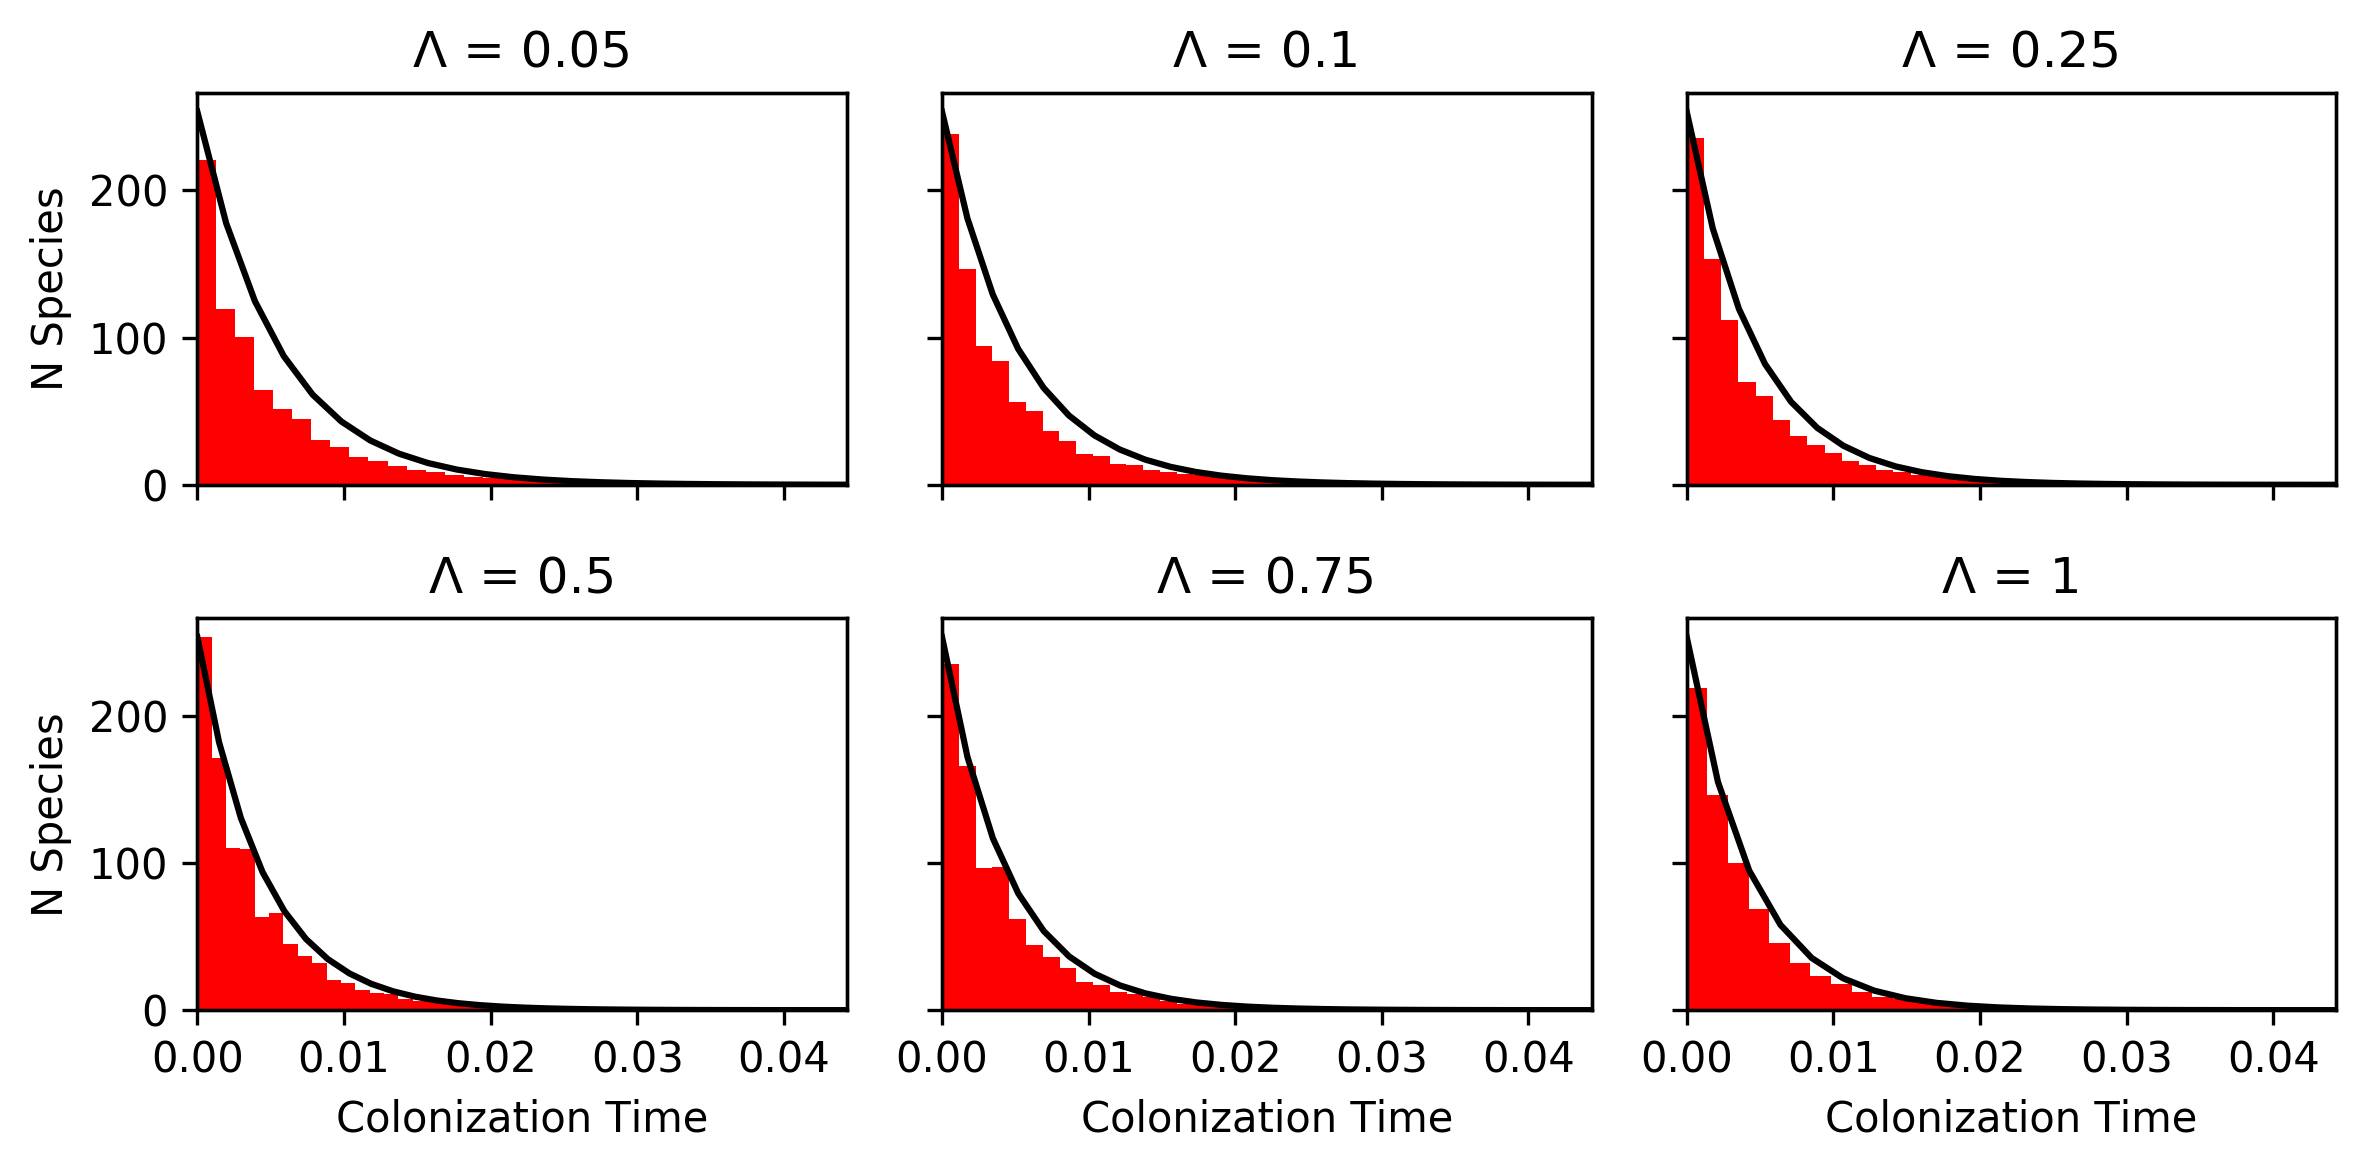

In [65]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[2:])
    lambda_dists[percent] = coltimes
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),

## Plot
plot_pidxy_per_lambda(lambda_dists, "Colonization Time", nbins=150)

# Do pi and Dxy
## Gather all the pi and dxy values vectors for all the simulations

In [7]:
files = glob.glob(SIMOUT_DIR + "*5000*/pidxy.txt")
pi_dat = []
dxy_dat = []
for f in files:
    lines = open(f).readlines()
    tmp_pi = []
    tmp_dxy = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            ldat = line.strip().split()
            l = [float(ldat[0])] + [float(x.translate(None, "[],")) for x in ldat[2:]]
            if "pi" in ldat:
                tmp_pi.append(l)
            else:
                tmp_dxy.append(l)
        except Exception as inst:
            print(inst)
    pi_dat.extend(tmp_pi)
    dxy_dat.extend(tmp_dxy)
print("Processed ntimepoints {} {}".format(len(pi_dat), len(dxy_dat)))
print(pi_dat[:1])


Processed ntimepoints 11994 11992
[[0.0594, 0.016361957525392427, 0.003000923361034164, 0.0018282548476454292, 0.0015327793167128345, 0.0, 0.00564173591874423, 0.0011819021237303785, 0.0, 0.0017543859649122805, 0.0007017543859649123, 0.003702677746999077, 0.000664819944598338, 0.006832871652816253, 0.00035087719298245617, 0.0017174515235457064, 0.0018097876269621423, 0.0033425669436749766, 0.01137580794090489, 0.0012557710064635273, 0.0, 0.0006925207756232687, 0.0025023084025854103, 0.001394275161588181, 0.015503231763619568, 0.001218836565096953, 0.008291782086795938, 0.009436749769159744, 0.006888273314866113, 0.0035180055401662046, 0.0034441366574330563, 0.0011080332409972298, 0.008365650969529086, 0.0011542012927054477, 0.003462603878116344, 0.007617728531855956, 0.0031763619575253923, 0.0057710064635272396, 0.0014496768236380425, 0.00035087719298245617, 0.010784856879039705, 0.0011172668513388735, 0.020923361034164367, 0.00172668513388735, 0.011505078485687902, 0.00052631578947368

## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

Got n coltimes per lambda:
0.25 - 29035	0.5 - 12084	0.05 - 56926	0.1 - 41095	1 - 312329	0.75 - 17486	Got n coltimes per lambda:
0.25 - 29035	0.5 - 12084	0.05 - 56926	0.1 - 41095	1 - 312329	0.75 - 17486	

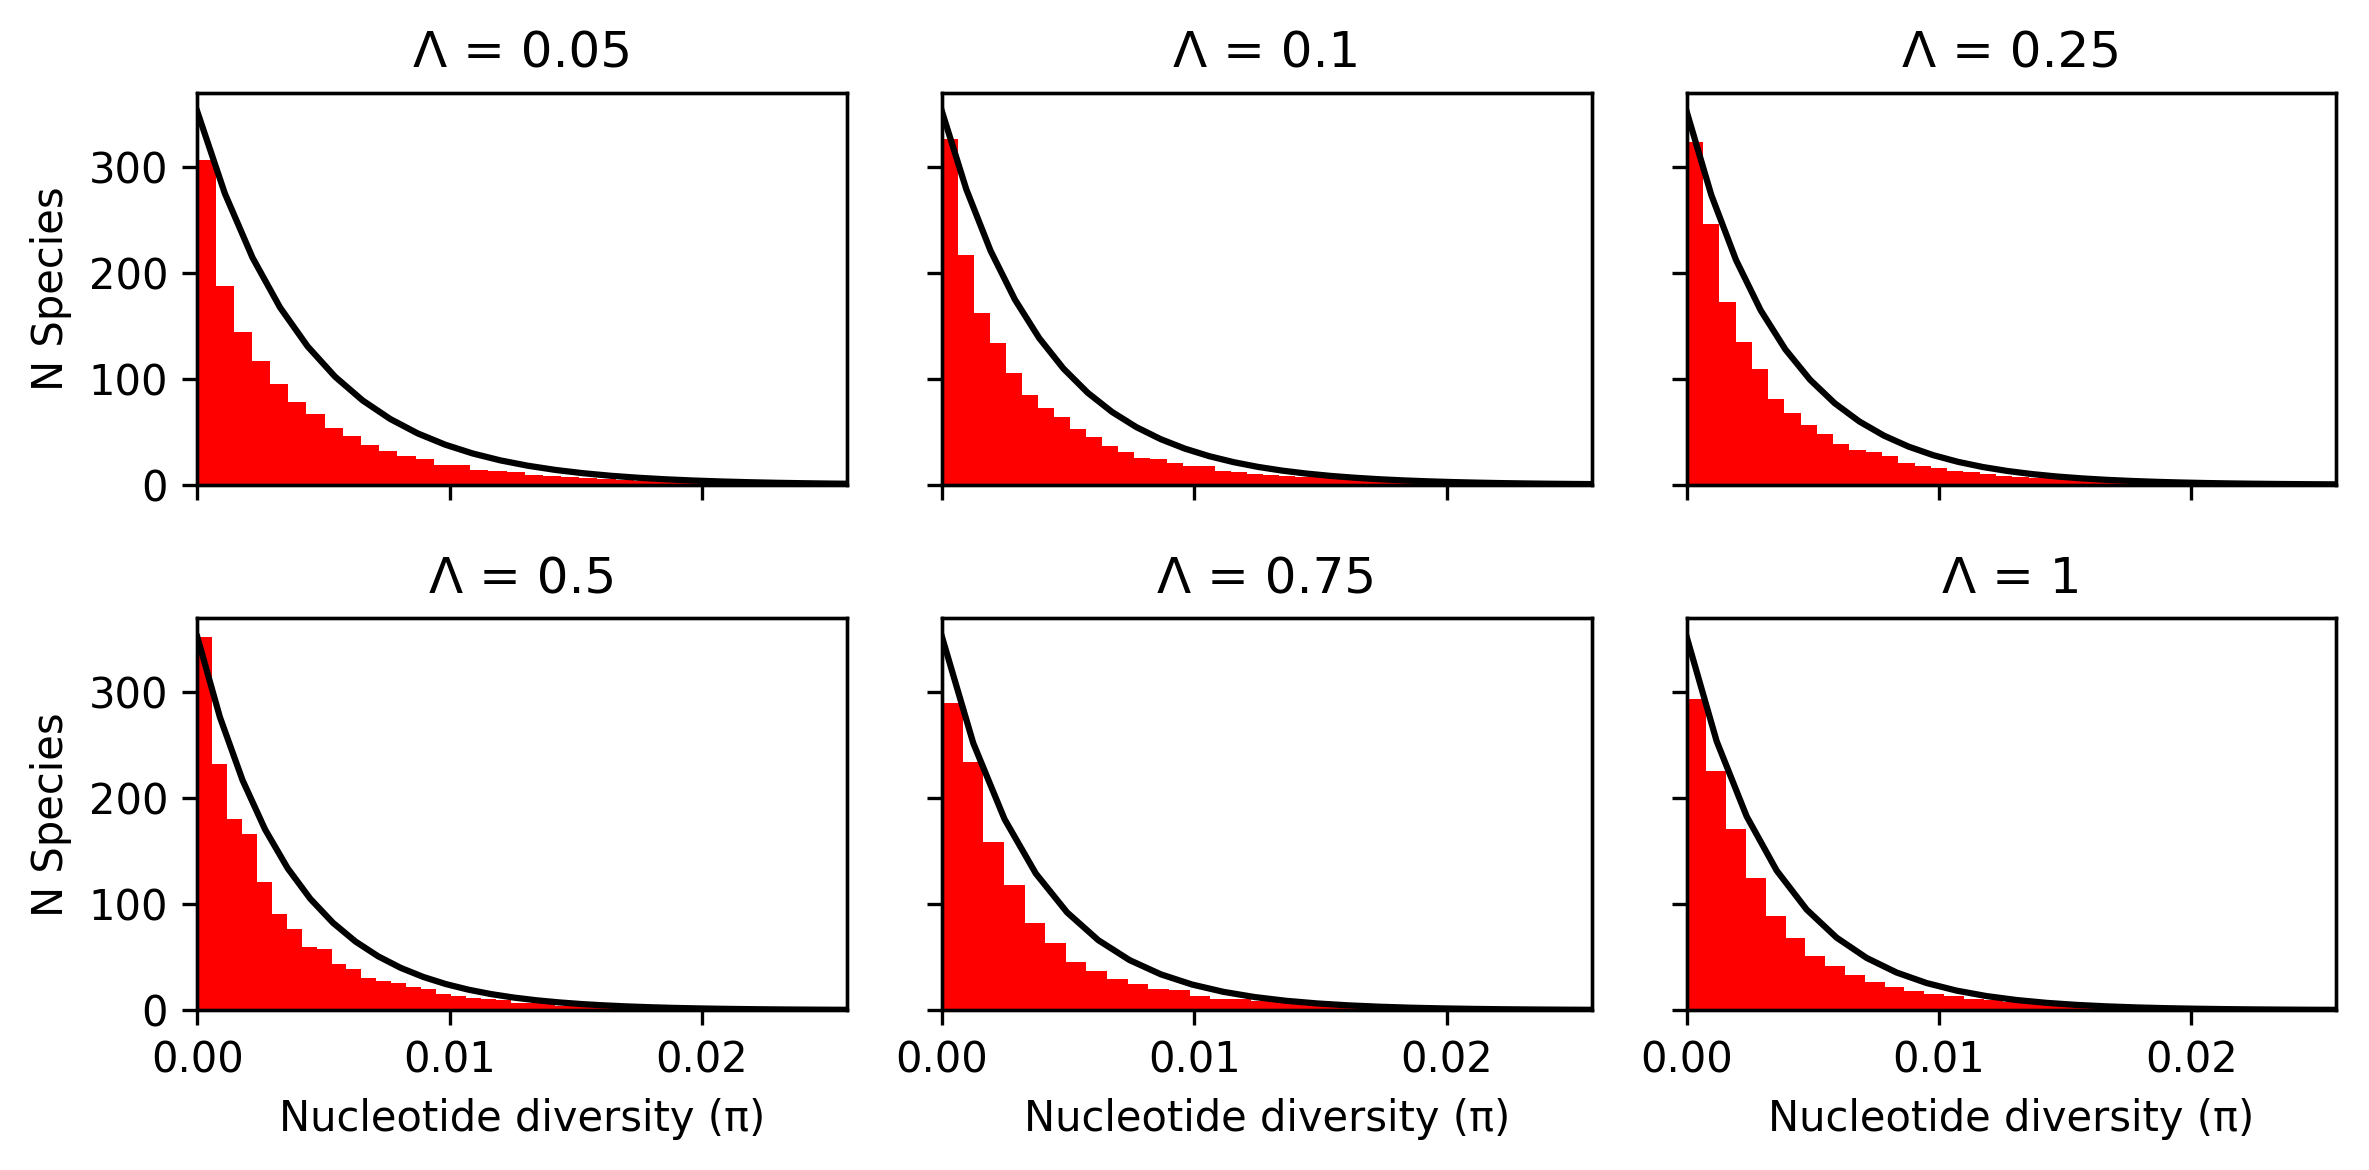

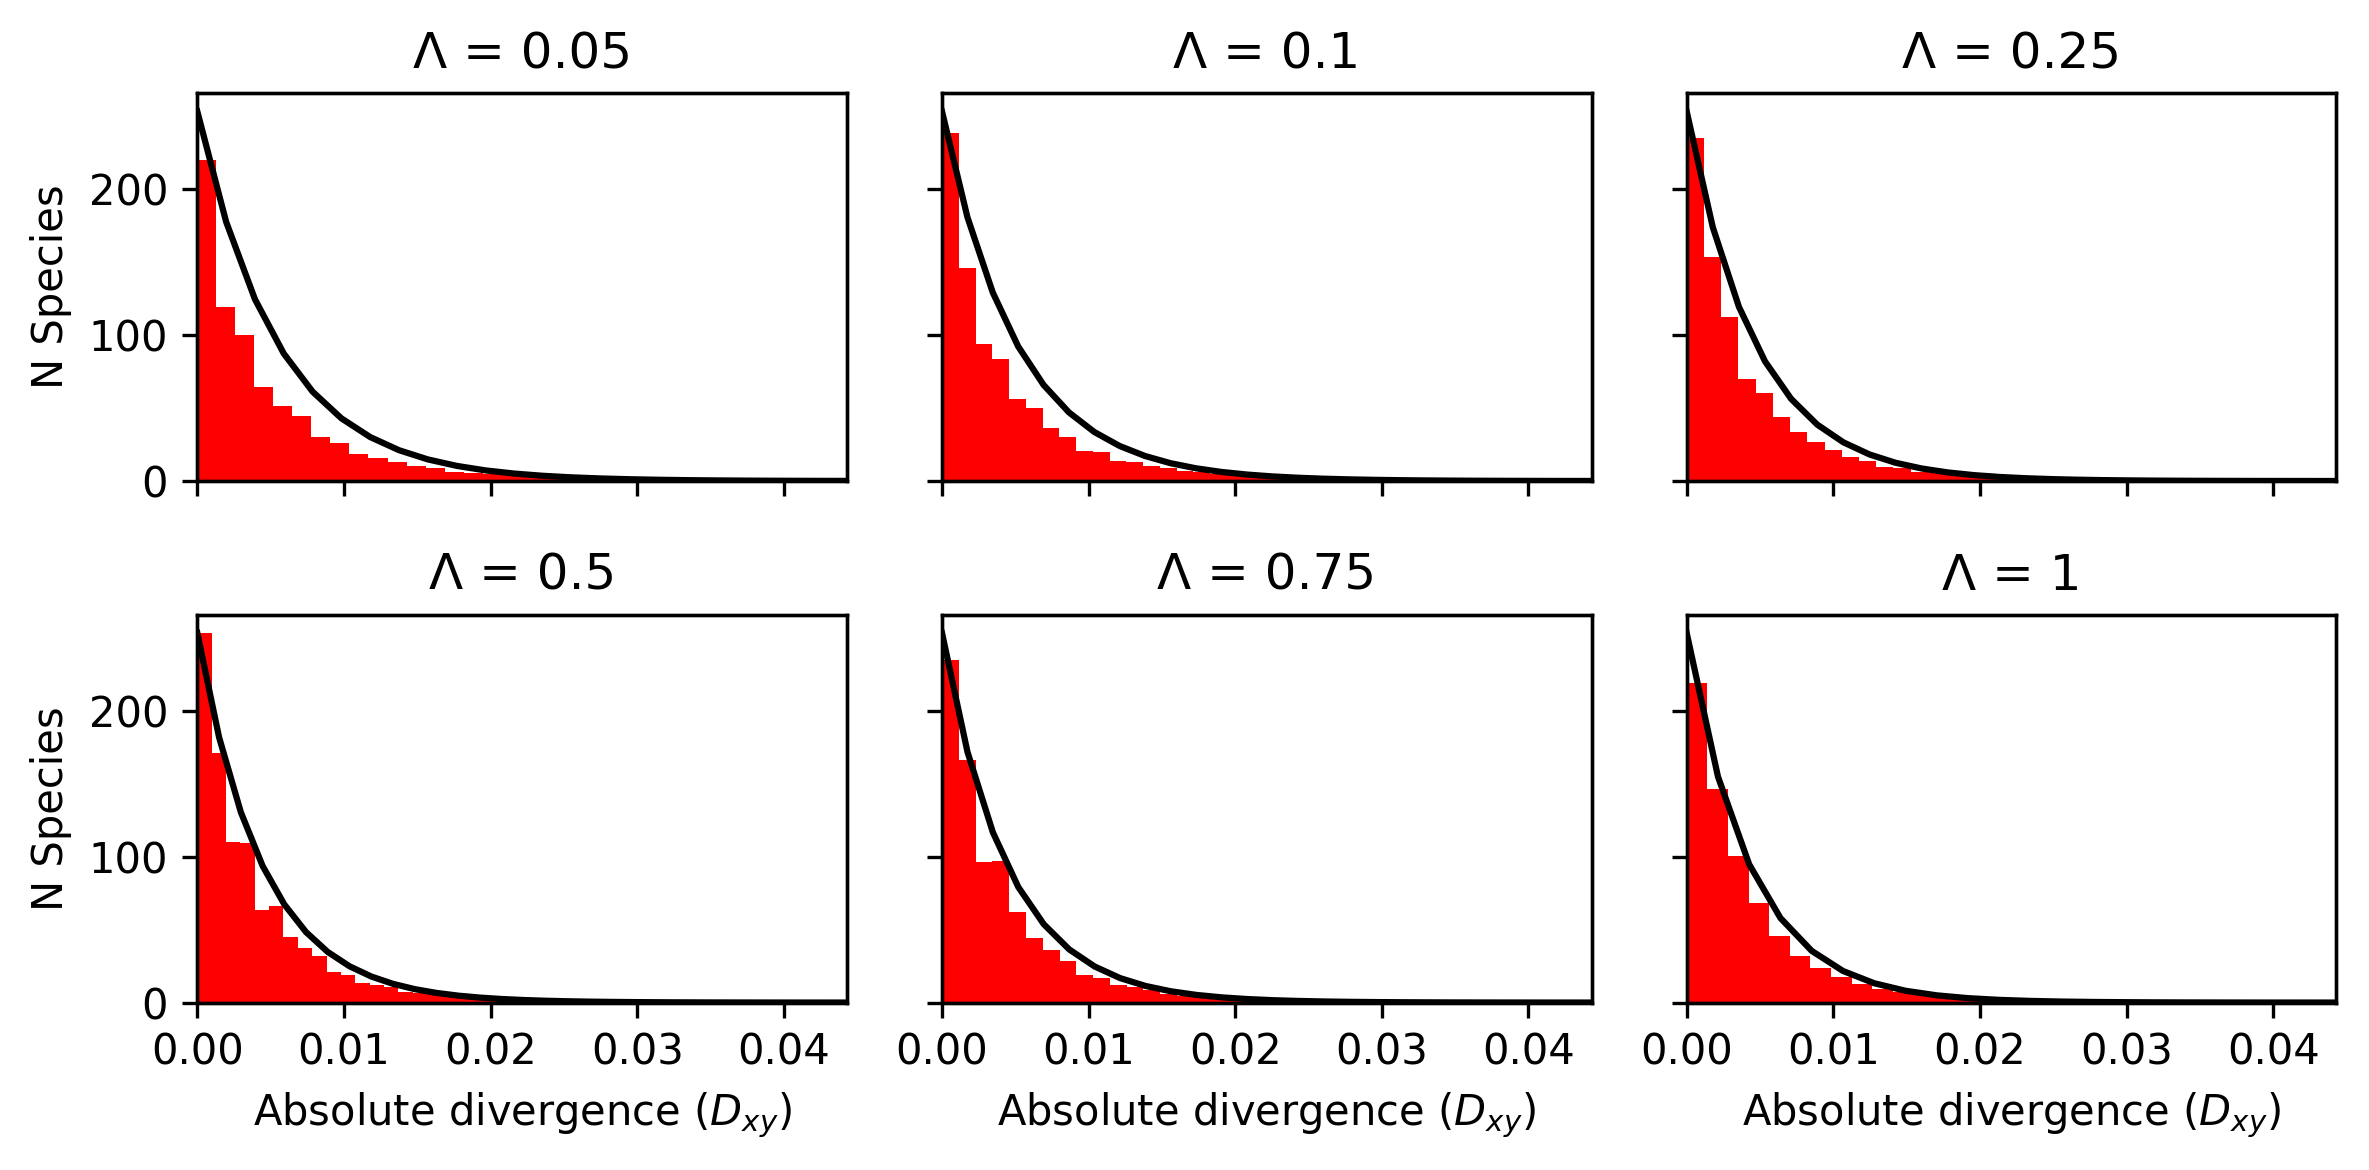

In [66]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
    lambda_dists = {perc:[] for perc in sampling_lambdas}
    ## Ineffecient but i don't care
    for percent in sampling_lambdas:
        coltimes = []
        for line in dat:
            ## If the difference between the lambda for each line
            ## is close enough to the sampling lambda we want then keep the coltimes
            if abs(line[0] - percent) < time_tolerance:
                coltimes.extend(line[2:])
        lambda_dists[percent] = coltimes
        #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
    print("Got n coltimes per lambda:")
    for k,v in lambda_dists.items():
        print("{} - {}\t".format(k, len(v))),

    ## Plot
    if "pi" in g:
        plot_pidxy_per_lambda(lambda_dists, u"Nucleotide diversity (π)", nbins=150)
    else:
        plot_pidxy_per_lambda(lambda_dists, r"Absolute divergence ($D_{xy}$)", nbins=150)

# **Shannon**
## Grab all the data from the sumstats file

In [5]:
files = glob.glob(SIMOUT_DIR + "*5000*/sumstats.txt")
dat = []
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = [float(x.translate(None, "[],")) for x in line.strip().split()]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 11526


# Crap below here

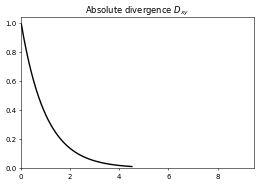

In [109]:
f, ax = plt.subplots(1,1, figsize=(6,4), dpi=50)
x = np.arange(expon.ppf(0.01), expon.ppf(0.99), .1)
rv = expon()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_xlim(0,x1*2)
ax.set_ylim(0,y1)
## Works
#ax.spines['left'].set_position(('axes', 0.03))
#ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position(('axes', 0.04))
#ax.spines['top'].set_color('none')
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
ax.set_title(r"Absolute divergence $D_{xy}$")

In [12]:
np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5))

array([      1,  500000,  999999, 1499998, 1999997, 2499996])

In [ ]:
plot_pidxy_per_lambda(lambda_dists, "Average pairwise distance", nbins=100)

AttributeError: Unknown property density

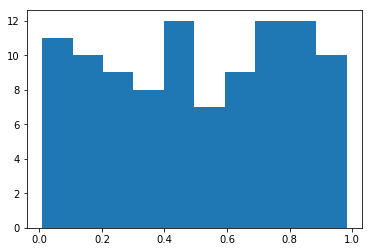

In [49]:
ax = plt.subplot(111)
ax.hist(np.random.uniform(0,1,100), )